In [24]:
%cd ~/Dropbox/programs/critic
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import wat

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

/home/nicholas/Dropbox/programs/critic


In [25]:
pd.read_feather('precomputed/all_typos2.feather')

,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char


In [26]:
metadata = pd.read_csv("data/keystrokes/metadata_participants.txt", sep="\t")
metadata.head()

,PARTICIPANT_ID,AGE,GENDER,HAS_TAKEN_TYPING_COURSE,COUNTRY,LAYOUT,NATIVE_LANGUAGE,FINGERS,TIME_SPENT_TYPING,KEYBOARD_TYPE,ERROR_RATE,AVG_WPM_15,AVG_IKI,ECPC,KSPC,ROR
0,3,30,none,0,US,qwerty,en,1-2,8,full,0.511945,61.9483,169.224722,0.052901,1.151877,0.2288
1,5,27,female,0,MY,qwerty,en,7-8,6,laptop,0.871080,72.8871,150.457375,0.031469,1.101399,0.3675
2,7,13,female,0,AU,qwerty,en,7-8,0,laptop,6.685633,24.1809,386.575303,0.092105,1.292398,0.0667
3,23,21,female,0,IN,qwerty,en,3-4,0,full,2.130493,24.7112,457.947902,0.016624,1.072890,0.0413
4,24,21,female,0,PH,qwerty,tl,7-8,1,laptop,1.893287,45.3364,223.913395,0.045296,1.177700,0.2678


## Participant Selection

For now, this project has a specific scope: people who are taking a USC CS class, and at least for
now people who are using laptops or desktops. That means we have a few things to filter out:

- Dealing with different keyboard layouts is fine, so long as we properly account for it.
- I think it makes the most sense to target an audience that is at least typing with most of their
  fingers: "hunt-and-peck" is just a very different kind of typing with its own potential mistakes,
  and I would guess the large majority of people in CS have at least learned to type reasonably
  well.
- We obviously want to look at the errors, but it doesn't make sense to consider people who have an
  abnormally large amount of errors: we'll filter out the outliers.

Seeing the "10+" option has piqued my interest: how do people with hexadactyly type? Am I missing
out?

We'll filter to 7-8 and above: we have plenty of data there.

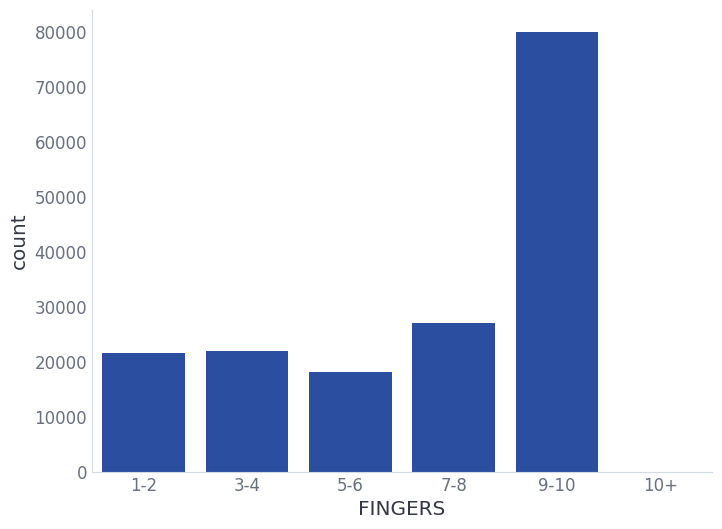

In [27]:
sns.countplot(metadata, x="FINGERS", order=["1-2", "3-4", "5-6", "7-8", "9-10", "10+"])
filtered = metadata.query('FINGERS == "7-8" or FINGERS == "9-10" or FINGERS == "10+"')

We'll filter to "full" and "laptop".

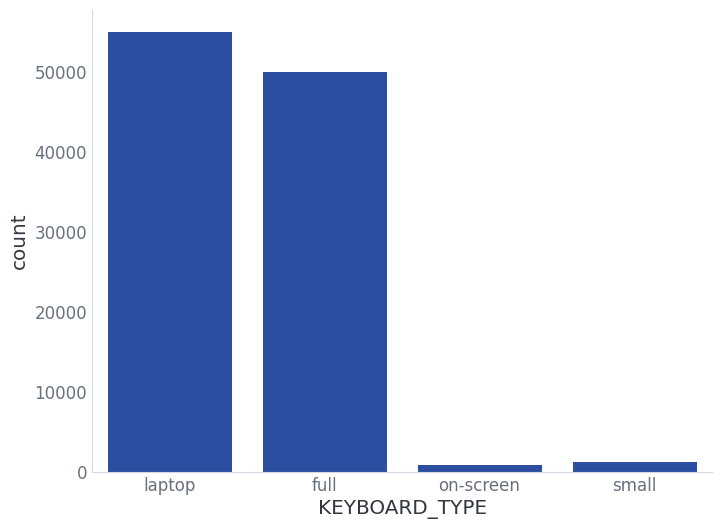

In [28]:
sns.countplot(filtered, x="KEYBOARD_TYPE")
filtered = filtered.query('KEYBOARD_TYPE == "full" or KEYBOARD_TYPE == "laptop"')

This distribution of typing speed looks quite natural, so we won't do any filtering on it.

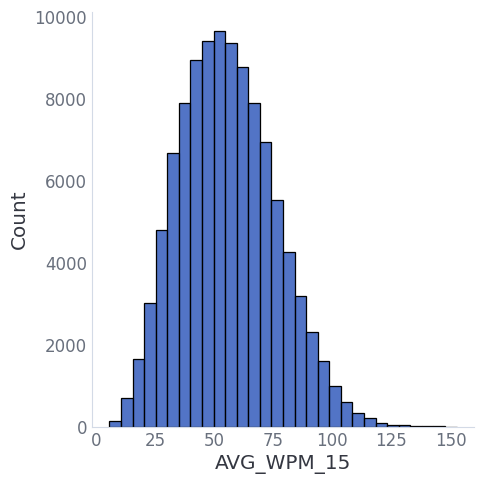

In [29]:
sns.displot(filtered, x="AVG_WPM_15", bins=30)

The errors per character does have a few outliers. We'll tentatively filtered out anyone who has
more than a 40% error rate.

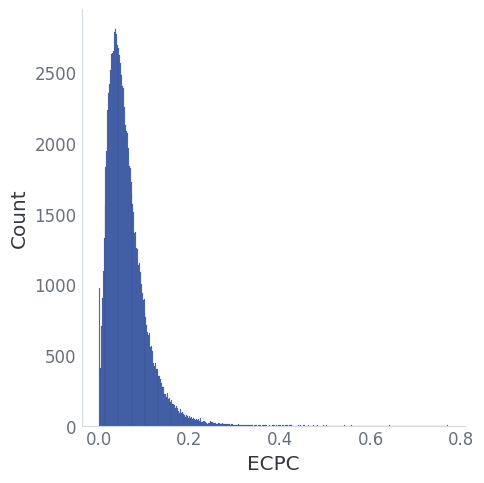

In [30]:
sns.displot(filtered, x="ECPC")
filtered = filtered.query("ECPC <= 0.4")

In [31]:
filtered

,PARTICIPANT_ID,AGE,GENDER,HAS_TAKEN_TYPING_COURSE,COUNTRY,LAYOUT,NATIVE_LANGUAGE,FINGERS,TIME_SPENT_TYPING,KEYBOARD_TYPE,ERROR_RATE,AVG_WPM_15,AVG_IKI,ECPC,KSPC,ROR
1,5,27,female,0,MY,qwerty,en,7-8,6,laptop,0.871080,72.8871,150.457375,0.031469,1.101399,0.3675
2,7,13,female,0,AU,qwerty,en,7-8,0,laptop,6.685633,24.1809,386.575303,0.092105,1.292398,0.0667
4,24,21,female,0,PH,qwerty,tl,7-8,1,laptop,1.893287,45.3364,223.913395,0.045296,1.177700,0.2678
5,25,19,male,0,IN,qwerty,en,7-8,1,laptop,0.747384,54.6831,190.034172,0.055389,1.146707,0.4434
6,30,20,female,1,AF,qwerty,en,7-8,4,laptop,3.127715,9.9978,728.222107,0.203267,1.511797,0.0049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168589,517932,20,male,0,US,qwerty,en,9-10,2,laptop,8.731466,24.9125,392.646012,0.116638,1.245283,0.1842
168590,517936,25,male,0,PL,qwerty,pl,9-10,1,laptop,0.000000,66.2946,166.587565,0.023932,1.095726,0.0639
168591,517943,38,female,1,US,qwerty,en,9-10,3,laptop,0.147929,75.6713,138.880622,0.057607,1.140325,0.2021
168592,517944,28,female,0,GB,qwerty,en,9-10,6,laptop,0.278552,91.7083,111.372849,0.050139,1.171309,0.5133


In [32]:
subj_id = filtered["PARTICIPANT_ID"].iloc[-3]

subj_data = pd.read_csv(f"data/keystrokes/{subj_id}_keystrokes.txt", sep="\t")
for col in ("PRESS_TIME", "RELEASE_TIME"):
    subj_data[col] = pd.to_datetime(subj_data[col], unit="ms")

i = 210
subj_data.iloc[i:i+20]

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE
210,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851582,2016-11-14 11:53:43.070,2016-11-14 11:53:43.159,t,84
211,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851584,2016-11-14 11:53:43.240,2016-11-14 11:53:43.328,a,65
212,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851586,2016-11-14 11:53:43.288,2016-11-14 11:53:43.360,r,82
213,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851588,2016-11-14 11:53:43.455,2016-11-14 11:53:43.512,t,84
214,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851591,2016-11-14 11:53:43.599,2016-11-14 11:53:43.662,,32
215,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851594,2016-11-14 11:53:43.720,2016-11-14 11:53:43.776,f,70
216,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851602,2016-11-14 11:53:43.848,2016-11-14 11:53:43.896,o,79
217,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851603,2016-11-14 11:53:43.968,2016-11-14 11:53:44.024,r,82
218,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851604,2016-11-14 11:53:44.064,2016-11-14 11:53:44.136,,32
219,517943,5579493,Chambers is still too inconsistent to start fo...,Chambers is still too inconsistent to start fo...,264851605,2016-11-14 11:53:44.208,2016-11-14 11:53:44.296,m,77


In [33]:
pd.unique(subj_data["LETTER"])

array(['SHIFT', 'R', 'o', 't', 'h', 'e', 'n', 'b', 'r', 'g', ' ', 's',
       'a', 'i', 'd', 'U', 'BKSP', 'E', 'u', 'p', 'w', 'y', 'f', 'm', 'c',
       '.', 'T', 'v', 'l', 'I', "'", 'C', 'F', 'k', 'W', '?', 'J', ',',
       'H', 'j', 'x', 'A', 'S', 'L', 'q'], dtype=object)

In [34]:
from chex import dataclass as _dataclass
from zipfile import ZipFile

dataclass = _dataclass(mappable_dataclass=False)


@dataclass
class KeyEvent:
    """Key event: either a press or release."""

    is_press: bool
    letter: str


BKSP = '␈'
OMIT = '¬'
SPACER = '␣'

@dataclass
class TextState:
    """State of typing, including SHIFT."""

    shift_down: bool = False
    typed_letters: str = ""
    all_letters: str = ""


def type_key(event: KeyEvent, state: TextState) -> TextState:    
    if event.letter == "SHIFT":
        return state.replace(shift_down=event.is_press)
    elif not event.is_press:
        # only pressing a key matters, unless it's shift
        return state    
    elif event.letter == "BKSP":
        return state.replace(typed_letters=state.typed_letters[:-1], all_letters=state.all_letters + BKSP)
    elif len(event.letter) == 1:  # single key press
        if state.shift_down:
            letter = event.letter.upper()
        else:
            letter = event.letter.lower()
        return state.replace(typed_letters=state.typed_letters + letter, all_letters=state.all_letters + letter)
    elif event.letter == 'CTRL':
        # ignore, I suppose?
        return state
    else:
        raise NotImplementedError(f'Support for {event.letter} not available right now.')


def parse_subj(subj_id):
    # with ZipFile('/home/nicholas/Downloads/Keystrokes.zip') as z:
    #     with z.open(f'Keystrokes/files/{subj_id}_keystrokes.txt') as f:
    #         subj_data = pd.read_csv(f, sep='\t', encoding='latin')

    subj_data = pd.read_csv(f"~/Downloads/Keystrokes/files/{subj_id}_keystrokes.txt", sep="\t", encoding='latin')
    # for col in ("PRESS_TIME", "RELEASE_TIME"):
    #     subj_data[col] = pd.to_datetime(subj_data[col], unit="ms")

    events = []
    for i, row in subj_data.iterrows():
        events.append((row['PRESS_TIME'], i, KeyEvent(True, row['LETTER'])))
        events.append((row['RELEASE_TIME'], i, KeyEvent(False, row['LETTER'])))

    events = sorted(events, key=lambda x: x[0])
    state = TextState()

    subj_data['text'] = ''
    subj_data['input_stream'] = ''

    flagged_sents = set()
    for _time, i, event in events:
        try:
            state = type_key(event, state)
        except NotImplementedError:
            flagged_sents.add(subj_data.loc[i, 'SENTENCE'])
        if event.is_press:
            ix = list(subj_data.index).index(i)
            if ix == len(subj_data.index) - 1 or len(pd.unique(subj_data['SENTENCE'].iloc[ix:ix+2])) == 2:                
                subj_data.loc[i, 'text'] = state.typed_letters
                subj_data.loc[i, 'input_stream'] = state.all_letters
                state = TextState()
    return subj_data[~subj_data['SENTENCE'].isin(flagged_sents)]

subj_data = parse_subj(subj_id)
subj_data

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE,text,input_stream
0,517943,5579477,Rothenberg said the trend in Europe was away f...,Rothenberg said te trend in Europe was away fr...,264850666,1479124389402,1479124389562,SHIFT,16,,
1,517943,5579477,Rothenberg said the trend in Europe was away f...,Rothenberg said te trend in Europe was away fr...,264850668,1479124389513,1479124389601,R,82,,
2,517943,5579477,Rothenberg said the trend in Europe was away f...,Rothenberg said te trend in Europe was away fr...,264850670,1479124389746,1479124389817,o,79,,
3,517943,5579477,Rothenberg said the trend in Europe was away f...,Rothenberg said te trend in Europe was away fr...,264850672,1479124389904,1479124389969,t,84,,
4,517943,5579477,Rothenberg said the trend in Europe was away f...,Rothenberg said te trend in Europe was away fr...,264850674,1479124390049,1479124390112,h,72,,
...,...,...,...,...,...,...,...,...,...,...,...
767,517943,5579550,Let me know if you have more questions.,Let me know if you have more questions.,264854199,1479124518061,1479124518141,i,84,,
768,517943,5579550,Let me know if you have more questions.,Let me know if you have more questions.,264854201,1479124518156,1479124518237,o,79,,
769,517943,5579550,Let me know if you have more questions.,Let me know if you have more questions.,264854203,1479124518244,1479124518326,n,78,,
770,517943,5579550,Let me know if you have more questions.,Let me know if you have more questions.,264854210,1479124518278,1479124518390,s,83,,


In [35]:
# https://faculty.washington.edu/wobbrock/pubs/tochi-06.pdf

from collections.abc import Sequence


@dataclass
class InputStream:
    text: str
    flags: Sequence[bool]
    positions: Sequence[int] = ()

    def __str__(self):
        out = []
        for letter, flag in zip(self.text, self.flags):
            if flag:
                out.append('\u0304' + letter)
            else:
                out.append(letter)

        return ''.join(out)

def flag_stream(input_stream: str):
    flags = np.zeros(len(input_stream), dtype=np.bool_)
    count = 0
    for i, letter in reversed(list(enumerate(input_stream))):
        if letter == BKSP:
            count += 1
        else:
            if count == 0:
                flags[i] = True
            else:
                count -= 1
    return InputStream(input_stream, flags)

# row = sent_data.iloc[-1]

# stream_text = row['input_stream']
# stream = flag_stream(stream_text)

# print(stream_text)
# print(stream)

def msd_matrix(p: str, t: str):
    d = np.zeros((len(p) + 1, len(t) + 1), dtype=np.uint16)

    d[:, 0] = np.arange(len(p) + 1)
    d[0, :] = np.arange(len(t) + 1)

    for i in range(1, len(p) + 1):
        for j in range(1, len(t) + 1):
            d[i, j] = min(
                d[i - 1, j] + 1,
                d[i, j - 1] + 1,
                d[i-1, j-1] + int(p[i - 1] != t[j - 1])
            )

    return d

def align(p, t, d, x, y, p1, t1, alignments):
    if x == y == 0:
        alignments.append((p1, t1))
        return alignments

    if x > 0 and y > 0:
        if d[x, y] == d[x - 1, y - 1] and p[x - 1] == t[y - 1]:
            align(p, t, d, x - 1, y - 1, p[x - 1] + p1, t[y - 1] + t1, alignments)            
        if d[x, y] == d[x - 1, y - 1] + 1:
            align(p, t, d, x - 1, y - 1, p[x - 1] + p1, t[y - 1] + t1, alignments)

    if x > 0 and d[x, y] == d[x - 1, y] + 1:
        align(p, t, d, x - 1, y, p[x - 1] + p1, OMIT + t1, alignments)

    if y > 0 and d[x, y] == d[x, y - 1] + 1:    
        align(p, t, d, x, y - 1, OMIT + p1, t[y - 1] + t1, alignments)   

    return alignments


def msd_align(p, t, d=None):
    if d is None:
        d = msd_matrix(p, t)

    alignments = []
    align(p, t, d, len(p), len(t), '', '', alignments)
    return alignments, d

def stream_align(input_stream: InputStream, alignments):
    triplets = []
    for p, t in alignments:
        stream = list(input_stream.text)
        flags = list(input_stream.flags)
        for i in range(max(len(t), len(stream))):
            if i < len(t) and t[i] == OMIT:
                stream.insert(i, SPACER)
                flags.insert(i, True)
            elif not flags[i]:
                p = p[:i] + SPACER + p[i:]
                t = t[:i] + SPACER + t[i:]
        triplets.append((p, t, InputStream(''.join(stream), flags)))

    return triplets

# alignments, d = msd_align(row['SENTENCE'][:len(row['text']) + 1], row['text'])
# print(stream)
# print()
# triplets = stream_align(stream, alignments)
# for a, b, c in triplets:
#     print(a, b, c, sep='\n')


def assign_position_values(triplets):    
    for p, t, i_s in triplets:
        i_s.positions = []
        pos = 0
        for i in range(len(i_s.text)):
            if i_s.flags[i]:
                i_s.positions.append(0)
                pos = 0
            else:
                if i_s.text[i] == BKSP and pos > 0:
                    pos -= 1
                
                i_s.positions.append(pos)   
                if i_s.text[i] != BKSP:
                    pos += 1

# assign_position_values(triplets)
# for a, b, c in triplets:
#     print(a, b, c, sep='\n')
#     print(''.join(map(str, c.positions)))

@dataclass
class Error:
    kind: str
    corrected: bool    
    i: int
    j: int | None = None


def look_ahead(s, start, count, predicate):
    index = start
    while 0 <= index < len(s) and not predicate(s[index]):
        index += 1

    while count > 0 and index < len(s):
        index += 1
        if index == len(s):
            break
        elif predicate(s[index]):
            count -= 1

    return index


def look_behind(s, start, count, predicate):
    index = start
    while 0 <= index < len(s) and not predicate(s[index]):
        index -= 1

    while count > 0 and index >= 0:
        index -= 1
        if index < 0:
            break
        elif predicate(s[index]):
            count -= 1

    return index

def is_letter(s):
    return s != BKSP


def determine_errors(triplets):
    all_errors = {}
    for p, t, i_s in triplets:
        errors = []
        a = 0
        for b in range(len(i_s.text)):
            if b < len(t) and t[b] == OMIT:
                errors.append(Error('omission', False, b))
            elif b == len(i_s.text) - 1 or i_s.flags[b]:
                omissions = set()
                insertions = set()
                for i in range(a, b):
                    is_i = i_s.text[i]
                    v = i_s.positions[i]
                    if is_i == BKSP:
                        omissions.discard(v)
                        insertions.discard(v)
                    elif is_i != '_':
                        target = look_ahead(p, b, v + len(omissions) - len(insertions), is_letter)
                        # skipping nonrecognized case
                        next_p = look_ahead(p, target, 1, is_letter)
                        prev_p = look_behind(p, target, 1, is_letter)
                        next_is = look_ahead(i_s.text, i, 1, lambda s: s != SPACER)
                        prev_is = look_behind(i_s.text, i, 1, lambda s: s != SPACER)
                        if target < len(p) and is_i == p[target]:
                            # corrected no error
                            pass
                        elif target >= len(p) or i_s.text[next_is] == p[target] or (i_s.text[prev_is] == is_i == p[prev_p]):
                            errors.append(Error('insertion', True, i))
                            insertions.add(v)
                        elif 0 <= next_p < len(p) and is_i == p[next_p] and target < len(t) and is_letter(t[target]):
                            errors.append(Error('omission', True, target))
                            # corrected no error IS[i]
                            omissions.add(v)
                        else:
                            errors.append(Error('substitute', True, target, i))

                if b < len(p):
                    if p[b] == OMIT:
                        errors.append(Error('insertion', False, b))
                    elif p[b] != t[b]:
                        errors.append(Error('substitute', False, b, b))
                    elif p[b] != SPACER:
                        # uncorrected no error
                        pass
                # skipping norec-insertion
                a = b + 1
        all_errors[(p, t, i_s.text)] = errors

    return all_errors

def print_errors(all_errors):
    for (p, t, ist), errors in all_errors.items():    
        print(p, t, ist, '', sep='\n')
        for error in errors:    
            if error.corrected:
                print('  corrected', error.kind, end='\t')
                i = error.i
                j = error.j
                if error.kind == 'insertion':
                    print(f'{ist[i]}={i}')
                elif error.kind == 'substitute':
                    print(f'({p[i]}={i} -> {ist[j]}={j})')
                elif error.kind == 'omission':
                    print(f'{p[i]}={i}')
            else:
                print('uncorrected', error.kind, end='\t')
                i = error.i
                j = error.j
                if error.kind == 'insertion':
                    print(f'{t[i]}={i}')
                elif error.kind == 'substitute':
                    print(f'({p[i]}={i} -> {t[j]}={j})')
                elif error.kind == 'omission':
                    print(f'{p[i]}={i}')  

# all_errs = determine_errors(triplets)
# print_errors(all_errs)

def all_errors(p, t, ist):
    alignments, d = msd_align(p, t)
    stream = flag_stream(ist)
    triplets = stream_align(stream, alignments)
    assign_position_values(triplets)
    all_errors = determine_errors(triplets)
    return all_errors


def min_err(all_errors):
    return min(len([e for e in errs if not e.corrected]) for errs in all_errors.values())


def to_text(ist):
    s = []
    for c in ist:
        if c == BKSP:
            if s:
                s.pop()
            else:
                pass
        else:
            s.append(c)

    return ''.join(s)

def find_best_alignments(p, t, ist, skip=0):
    if BKSP not in ist:
        return all_errors(p, t, ist), ist
    else:        
        i = 0        
        skipped = skip
        for i, l in enumerate(ist):            
            if l == BKSP and skipped == 0:
                # test if adding more backspaces would make alignment better
                best_ist = ist
                best_align = all_errors(p, t, ist)                
                best_err = min_err(best_align)
                best_bksp = 1
                num_bksp = 2
                new_ist = best_ist                
                while i - num_bksp >= 0 and ist[i + 1 - num_bksp] != BKSP:
                    new_ist = new_ist[:i] + BKSP + new_ist[i:]
                    new_t = to_text(new_ist)
                    if new_t is None:
                        break
                    next_align = all_errors(p, new_t, new_ist)                
                    next_err = min_err(next_align)  
                    # print(new_ist, '-', new_t, '-', next_align, next_err)  
                    if next_err < best_err:
                        best_align = next_align
                        best_err = next_err
                        best_ist = new_ist
                        best_bksp = num_bksp
                    elif next_err > best_err:
                        break

                
                    num_bksp += 1
                        
                return find_best_alignments(p, to_text(best_ist), best_ist, skip+best_bksp)
            elif l == BKSP:
                skipped -= 1
            i += 1
                        
        return all_errors(p, t, ist), ist
    

find_best_alignments('Please feel', 'PleasPlease feel', 'PLease' + BKSP + 'Please' + ' feel')

({('␣␣␣␣␣␣␣␣␣␣␣␣Please feel',
   '␣␣␣␣␣␣␣␣␣␣␣␣Please feel',
   'PLease␈␈␈␈␈␈Please feel'): [Error(kind='substitute', corrected=True, i=13, j=1)]},
 'PLease␈␈␈␈␈␈Please feel')

In [36]:
def context(p, i):
    """Gets the text up to index i and the subsequent letter, removing spacers."""
    return p[:i+1].replace(SPACER, '') + (p[i+1:].replace(SPACER, '') + '__')[:2]

def collect_errors(subj_data):

    err_df = []
    for sent in pd.unique(subj_data['SENTENCE']):
        last_row = subj_data.query('SENTENCE == @sent').iloc[-1]
        # display(last_row)

        try:
            errors, curr_ist = find_best_alignments(sent, last_row['text'], last_row['input_stream'])
        except IndexError as e:
            print(e)
            continue
        except Exception as e:
            # print(dict(last_row))
            raise e
        for (p, t, ist), errs in errors.items():
            for error in errs:
                i = error.i
                j = error.j
                row = {
                    'kind': error.kind,
                    'corrected': error.corrected,
                    'participant': last_row['PARTICIPANT_ID'],
                    'weight': 1 / len(errors),
                    'p': p,
                    't': t,
                    'ist': ist,
                    'i': i,
                    'j': j,
                    'context': context(p, i),                
                }   
                if error.corrected:
                    user_text = ist
                else:
                    user_text = t              
                if error.kind == 'insertion':
                    row['wrong_char'] = user_text[i]
                    row['right_char'] = row['context'][-2]
                elif error.kind == 'substitute':
                    row['wrong_char'] = user_text[j]
                    row['right_char'] = p[i]                
                elif error.kind == 'omission':
                    row['wrong_char'] = row['context'][-2]
                    row['right_char'] = p[i]

                err_df.append(row)

    err_df = pd.DataFrame(err_df)
    return err_df

collect_errors(subj_data)

,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,False,517943,1.0,Rothenberg said the trend in ␣␣Europe was away...,Rothenberg said t¬e trend in ␣␣Europe was away...,Rothenberg said t␣e trend in U␈Europe was away...,17,NaN,Rothenberg said the,e,h
1,substitute,True,517943,1.0,Rothenberg said the trend in ␣␣Europe was away...,Rothenberg said t¬e trend in ␣␣Europe was away...,Rothenberg said t␣e trend in U␈Europe was away...,18,17.0,Rothenberg said the t,␣,e
2,substitute,True,517943,1.0,Rothenberg said the trend in ␣␣Europe was away...,Rothenberg said t¬e trend in ␣␣Europe was away...,Rothenberg said t␣e trend in U␈Europe was away...,31,29.0,Rothenberg said the trend in Eur,U,E
3,omission,True,517943,1.0,I wou␣␣ldn't wor␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ry about comin...,I wou␣␣ldn't wor␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ry about comin...,I woud␈ldn't wory about ␈␈␈␈␈␈␈␈ry about comin...,7,NaN,I wouldn,d,l
4,omission,True,517943,1.0,I wou␣␣ldn't wor␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ry about comin...,I wou␣␣ldn't wor␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ry about comin...,I woud␈ldn't wory about ␈␈␈␈␈␈␈␈ry about comin...,32,NaN,I wouldn't worry,y,r
5,substitute,True,517943,1.0,I wou␣␣ldn't wor␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ry about comin...,I wou␣␣ldn't wor␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ry about comin...,I woud␈ldn't wory about ␈␈␈␈␈␈␈␈ry about comin...,54,52.0,I wouldn't worry about coming in toda,i,o
6,substitute,True,517943,1.0,Chambers is still too in␣␣consistent to start ...,Chambers is still too in␣␣consistent to start ...,Chambers is still too ins␈consistent to start ...,26,24.0,Chambers is still too incon,s,c
7,omission,True,517943,1.0,I am hopin␣␣␣␣␣␣␣␣g to complete them today or ...,I am hopin␣␣␣␣␣␣␣␣g to complete them today or ...,I am hopin to ␈␈␈␈g to complete them today or ...,18,NaN,I am hoping t,,g
8,substitute,True,517943,1.0,It reads li␣␣ke she is in.,It reads li␣␣ke she is in.,It reads lis␈ke she is in.,13,11.0,It reads like,s,k
9,omission,False,517943,1.0,What is happening to the stock price?,What is happening to ¬he stock price?,What is happening to ␣he stock price?,21,NaN,What is happening to the,h,t


In [37]:
from pathlib import Path
from tqdm import tqdm
all_errs = []
# for path in Path("data/keystrokes/").glob('*_keystrokes.txt'):
#     subj_id = path.name.split('_')[0]
#     if int(subj_id) not in set(filtered['PARTICIPANT_ID']):
#         continue
for subj_id in tqdm([24139]):
    try:
        subj_data = parse_subj(subj_id)
    except Exception as e:
        print(e)
        continue
    
    try:
        all_errs.append(collect_errors(subj_data))
    except Exception as e:
        if 'string index' in str(e):
            raise e
        print(subj_id, e)

df = pd.concat(all_errs)
for cat_col in ('participant', 'p', 't', 'ist'):
    df[cat_col] = df[cat_col].astype('category')

df['kind'] = pd.Categorical(df['kind'], categories=('insertion', 'omission', 'substitute', 'transpose'))
df = df.reset_index(drop=True)
df

  0%|          | 0/1 [00:00<?, ?it/s]

string index out of range


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,True,24139,1.0,I hope that you find these comm␣␣unications in...,I hope that you find these comm␣␣unications in...,I hope that you find these commn␈unications in...,33,NaN,I hope that you find these communi,n,u
1,omission,True,24139,1.0,I hope that you find these comm␣␣unications in...,I hope that you find these comm␣␣unications in...,I hope that you find these commn␈unications in...,51,NaN,I hope that you find these communications inform,r,o
2,omission,True,24139,1.0,I hope that you find these comm␣␣unications in...,I hope that you find these comm␣␣unications in...,I hope that you find these commn␈unications in...,53,NaN,I hope that you find these communications info...,a,m
3,insertion,True,24139,1.0,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we reveiw␈␈␈iew with El Paso?,14,NaN,When do we revie,e,i
4,omission,True,24139,1.0,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we reveiw␈␈␈iew with El Paso?,21,NaN,When do we review,w,e
...,...,...,...,...,...,...,...,...,...,...,...,...
91,substitute,True,24139,1.0,The s␣␣␣␣eco␣␣nd deal in questi␣␣on which ␣␣ne...,The s␣␣␣␣eco␣␣nd de¬l in questi␣␣on wh¬ch ␣␣ne...,The soe␈␈ecod␈nd de␣l in questin␈on wh␣ch d␈ne...,39,38.0,The second deal in question which,␣,c
92,substitute,True,24139,1.0,The s␣␣␣␣eco␣␣nd deal in questi␣␣on which ␣␣ne...,The s␣␣␣␣eco␣␣nd de¬l in questi␣␣on wh¬ch ␣␣ne...,The soe␈␈ecod␈nd de␣l in questin␈on wh␣ch d␈ne...,44,42.0,The second deal in question which nee,d,n
93,omission,True,24139,1.0,The s␣␣␣␣eco␣␣nd deal in questi␣␣on which ␣␣ne...,The s␣␣␣␣eco␣␣nd de¬l in questi␣␣on wh¬ch ␣␣ne...,The soe␈␈ecod␈nd de␣l in questin␈on wh␣ch d␈ne...,57,NaN,The second deal in question which needs to b,,o
94,omission,True,24139,1.0,The s␣␣␣␣eco␣␣nd deal in questi␣␣on which ␣␣ne...,The s␣␣␣␣eco␣␣nd de¬l in questi␣␣on wh¬ch ␣␣ne...,The soe␈␈ecod␈nd de␣l in questin␈on wh␣ch d␈ne...,69,NaN,The second deal in question which needs to be ...,e,v


In [38]:
df.iloc[[82]]

,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
82,insertion,True,24139,1.0,I think in this case ␣␣␣␣␣␣specific is better.,I think in this case ␣␣␣␣␣␣specific is better.,I think in this case ps␈s␈␈specific is better.,21,NaN,I think in this case sp,p,s


In [39]:
df['transpose_1'] = False
df['transpose_2'] = False
for i in range(len(df.index) - 1):
    row1 = df.iloc[i]
    row2 = df.iloc[i+1]

    if ((row1['kind'] == 'insertion' and row2['kind'] == 'omission') and
        (row1['wrong_char'] == row2['right_char']) and
        (('_' + row2['context'])[-3] == row1['right_char'])):
        df.loc[row1.name, 'transpose_1'] = True
        df.loc[row2.name, 'transpose_2'] = True
        display(df.iloc[i:i+2])    

    if (row1['kind'] == 'insertion' and
        row1['context'][-1] == row1['wrong_char']):
        df.loc[row1.name, 'transpose_1'] = True
        display(df.iloc[i:i+1])
    

df.loc[df['transpose_1'], 'kind'] = 'transpose'
# df = df.query('not transpose_2').drop(columns=['transpose_1', 'transpose_2'])
df.query('kind == "transpose"')

,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char,transpose_1,transpose_2
3,insertion,True,24139,1.0,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we reveiw␈␈␈iew with El Paso?,14,NaN,When do we revie,e,i,True,False


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char,transpose_1,transpose_2
15,insertion,True,24139,1.0,We␣␣␣␣'ve pu␣␣r␣␣␣␣sued o␣␣␣␣␣␣␣␣␣␣ther option...,We␣␣␣␣'ve pu␣␣r␣␣␣␣sued o␣␣␣␣␣␣␣␣␣␣ther option...,We;v␈␈'ve pue␈rus␈␈sued orther␈␈␈␈␈ther option...,15,NaN,We've pursu,u,s,True,False


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char,transpose_1,transpose_2
82,insertion,True,24139,1.0,I think in this case ␣␣␣␣␣␣specific is better.,I think in this case ␣␣␣␣␣␣specific is better.,I think in this case ps␈s␈␈specific is better.,21,NaN,I think in this case sp,p,s,True,False


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char,transpose_1,transpose_2
3,transpose,True,24139,1.0,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we rev␣␣␣␣␣␣iew with El Paso?,When do we reveiw␈␈␈iew with El Paso?,14,NaN,When do we revie,e,i,True,False
15,transpose,True,24139,1.0,We␣␣␣␣'ve pu␣␣r␣␣␣␣sued o␣␣␣␣␣␣␣␣␣␣ther option...,We␣␣␣␣'ve pu␣␣r␣␣␣␣sued o␣␣␣␣␣␣␣␣␣␣ther option...,We;v␈␈'ve pue␈rus␈␈sued orther␈␈␈␈␈ther option...,15,NaN,We've pursu,u,s,True,False
82,transpose,True,24139,1.0,I think in this case ␣␣␣␣␣␣specific is better.,I think in this case ␣␣␣␣␣␣specific is better.,I think in this case ps␈s␈␈specific is better.,21,NaN,I think in this case sp,p,s,True,False


In [40]:
# df.to_feather('precomputed/typos.feather')

<Axes: xlabel='kind', ylabel='count'>

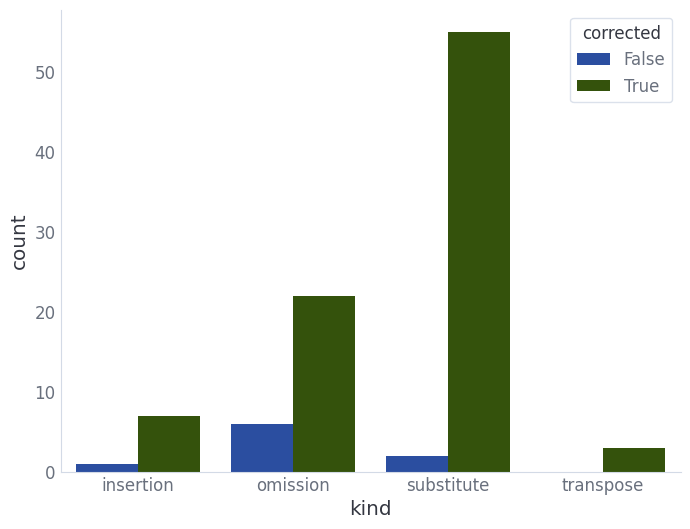

In [41]:
sns.countplot(df, x='kind', hue='corrected')

In [42]:
(1 / df['weight']).astype(int).value_counts()

weight
1    64
2    32
Name: count, dtype: int64